# Run ensemble SUMMA model on HPC with CyberGISX Job Submission 2.0 (Dev)

### Retrieve a SUMMA model instance resource from HydroShare

#### For more info on this resource https://www.hydroshare.org/resource/13d6b84a9553410297a67fa366a56cb2/

In [3]:
resource_id = '13d6b84a9553410297a67fa366a56cb2'

In [4]:
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
base_dir = os.getcwd() + '/examples'
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

In [1]:
base_dir = os.getcwd() + '/examples'
download_dir = os.path.join(base_dir, 'Downloads')

In [4]:
#Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
import tempfile
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance.zip
   creating: /Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpb57dednd/SummaModel_ReynoldsAspenStand_StomatalResistance/
   creating: /Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpb57dednd/SummaModel_ReynoldsAspenStand_StomatalResistance/data/
   creating: /Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpb57dednd/SummaModel_ReynoldsAspenStand_StomatalResistance/data/forcingData/
  inflating: /Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpb57dednd/SummaModel_ReynoldsAspenStand_StomatalResistance/data/forcingData/forcing_above_aspen.nc  
   creating: /Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpb57dednd/SummaModel_ReynoldsAspenStand_StomatalResistance/data/gis/
 extracting: /Users/erichsiao/Documents/Proje

In [5]:
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


### Use pySUMMA to build ensembles

In [8]:
import pysumma as ps
import os

executable = "/usr/bin/summa.exe"
! {executable} --version

# path to the SUMMA filemanager file on Jupyter
file_manager = os.path.join(model_source_folder_path, file_manger_rel_path)
print(file_manager)

/bin/sh: /usr/bin/summa.exe: No such file or directory
/Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpe_4pw0u7/SummaModel_ReynoldsAspenStand_StomatalResistance/settings/summa_fileManager_riparianAspenSimpleResistance.txt


In [9]:
# Create pySUMMA Simulation Object
S = ps.Simulation(executable, file_manager)

# Configure the model
S.manager['simStartTime'].value  = "2006-07-01 00:00"
S.manager['simEndTime'].value = "2007-09-30 00:00"
# Save configiuration to disk
S.manager.write()
print(S.decisions)

/Users/erichsiao/Documents/Project/CyberGIS/job-supervisor-python-sdk/examples/workspace/tmpe_4pw0u7/SummaModel_ReynoldsAspenStand_StomatalResistance/settings/ GENPARM.TBL
soilCatTbl    ROSETTA              ! soil-category dataset
vegeParTbl    USGS                 ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    simpleResistance     ! choice of function for stomatal resistance
num_method    itertive             ! choice of numerical method
fDerivMeth    analytic             ! choice of method to calculate flux derivatives
LAI_method    specified            ! choice of method to determine LAI and SAI
f_Richards    mixdform             ! form of Richards equation
groundwatr    noXplict             ! choice of groundwater parameterization
hc_profile    constant             ! choice of hydraulic conductivity profile
bcUpprTdyn    nrg_flux             ! type of upper boundary condition f

In [10]:
import numpy as np
import json
# create ensemble
# different parameterizations
param_options = {
    'rootDistExp': np.array([1.0, 0.5, 0.25])
}

# different parameterizations
decision_options = {
    "stomResist": ["BallBerry", "Jarvis", "simpleResistance"]
}

config = ps.ensemble.total_product(dec_conf=decision_options, param_trial_conf=param_options)

with open(os.path.join(model_source_folder_path, 'summa_options.json'), 'w') as outfile:
    json.dump(config, outfile)

# check ensemble parameters    
print("Number of ensemble runs: {}".format(len(config)))
print(json.dumps(config, indent=4, sort_keys=True)[:800])
print("...")

Number of ensemble runs: 9
{
    "++BallBerry++rootDistExp=0.25++": {
        "attributes": {},
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {},
        "trial_parameters": {
            "rootDistExp": 0.25
        }
    },
    "++BallBerry++rootDistExp=0.5++": {
        "attributes": {},
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {},
        "trial_parameters": {
            "rootDistExp": 0.5
        }
    },
    "++BallBerry++rootDistExp=1.0++": {
        "attributes": {},
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {},
        "trial_parameters": {
            "rootDistExp": 1.0
        }
    },
    "++Jarvis++rootDistExp=0.25++": {
        "attributes": {},
      
...


### Submit model to HPC using New Job Submission Service Python Client

In [6]:
from job_supervisor_client import *

job = Job(maintainer="SUMMA", hpc="keeling_community", url="localhost", port=3000, protocol='HTTP')

b''
localhost:3000 POST auth/job {'hpc': 'keeling_community', 'maintainer': 'SUMMA'}


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [10]:
communitySummaJob = communitySummaSession.job() # create new job

In [11]:
communitySummaJob.upload(model_source_folder_path)

{'file': '16007487614Qiz'}

In [12]:
communitySummaJob.submit(payload={
    "node": 9,
    "machine": "keeling"
})

✅ job registered with ID: 1600748763SWSW


In [13]:
communitySummaJob.events(liveOutput=True)

📮Job ID: 1600748763SWSW
📍Destination: summa



types,message,time
JOB_QUEUED,"job [1600748763SWSW] is queued, waiting for registration",2020-09-22T04:26:03.364Z
JOB_REGISTERED,"job [1600748763SWSW] is registered with the supervisor, waiting for initialization",2020-09-22T04:26:03.796Z
SUMMA_HPC_CONNECTED,connected to HPC,2020-09-22T04:26:10.788Z
SUMMA_HPC_SUBMITTED,submitted SUMMA job to HPC,2020-09-22T04:26:10.789Z
JOB_INITIALIZED,initialized SUMMA job in HPC job queue with remote_id 3607842,2020-09-22T04:26:10.789Z
JOB_ENDED,SUMMA job with remote_id 3607842 completed,2020-09-22T04:26:36.808Z


In [14]:
job_dir = os.path.join(workspace_dir, "{}".format(communitySummaJob.id))
!mkdir {job_dir}
communitySummaJob.download(job_dir)

file successfully downloaded under: /home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/1600748763SWSW.zip


### Check model output  -- NetCDF files

In [15]:
!cd {job_dir} && unzip *.zip

# check output directory
output_path = os.path.join(job_dir, "output")
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list if i.endswith(".nc")]
sorted_list = sorted(full_list)

for f in sorted_list:
    print(f)
print("Number of NC files: {}".format(len(sorted_list)))

Archive:  1600748763SWSW.zip
   creating: 16007487614Qiz/
   creating: 16007487614Qiz/data/
   creating: 16007487614Qiz/data/forcingData/
  inflating: 16007487614Qiz/data/forcingData/forcing_above_aspen.nc  
   creating: 16007487614Qiz/data/gis/
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.cpg  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.dbf  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.prj  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.sbn  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.sbx  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.shp  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.shp.xml  
  inflating: 16007487614Qiz/data/gis/Reynolds_Creek_watershed_wgs84.shx  
  inflating: 16007487614Qiz/data/gis/study_area.jpg  
   creating: 16007487614Qiz/data/validationData/
  inflating: 16007487614Qiz/data/validationData/Reynold

### Plot time series for total evapotranspiration (total ET)

In [16]:
out_file_paths = [[s] for s in sorted_list]
out_file_paths

[['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.25++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.5++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=1.0++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++Jarvis++rootDistExp=0.25++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++Jarvis++rootDistExp=0.5++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++Jarvis++rootDistExp=1.0++_timestep.nc'],
 ['/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/ou

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Create Method to Calculate Total ET for Each Hour of Day from SUMMA Output
def calc_total_et(et_output_df):
    total_et_data = (et_output_df['scalarLatHeatTotal'])*3600/2260000
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-05-31 23:00:00":"2007-08-20 23:00:00"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    total_et_by_hour.index.name = 'hour'
    total_et_by_hour.columns = ['ET']
    # calculate 3 hour moving average
    total_et_by_hour.loc['24'] = total_et_by_hour.loc[0].values
    for index in range(1,23,1):
        total_et_by_hour['ET'][index] = (total_et_by_hour['ET'][index-1]+total_et_by_hour['ET'][index]+total_et_by_hour['ET'][index+1])/3
    return total_et_by_hour

# Add Obervation Data from Aspen station in Reynolds Mountain East
file_manager.split('/settings')[0]+'/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc'
# create pySUMMA Plotting Object
Val_eddyFlux = xr.open_dataset(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')
# read Total Evapotranspiration(LE-wpl) AND Wind(WindFlag) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux['LE-wpl']
Obs_Wind = Val_eddyFlux['WindFlag']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# create obs_data(Y-axis) attribute from validation netcdf file
obs_evap = Obs_Evapotranspitaton.data
obs_wind = Obs_Wind.data
# create two dimensional tabular data structure 
df_evap = pd.DataFrame(obs_evap, index=dates)
df_wind = pd.DataFrame(obs_wind, index=dates)
# set the time period to display plot
df_evap_filt = df_evap.loc["2007-05-31 23:00:00":"2007-08-20 22:30:00"]
df_wind_filt = df_wind.loc["2007-05-31 23:00:00":"2007-08-20 22:30:00"]   #"2007-06-01":"2007-08-20"
# select aspen obervation station among three different stations
df_evap_filt.columns = ['-','Obs_evap (aspen)','-']
df_wind_filt.columns = ['-','Obs_wind (aspen)','-']
# Combine total evapotranspiration and wind data
obs_output = pd.concat([df_evap_filt['Obs_evap (aspen)'], df_wind_filt['Obs_wind (aspen)']], axis=1)
# add hour column
obs_output['hour'] = obs_output.index.hour
# drop NaN and select row of wind = 0
obs_output1 = obs_output.dropna()
hourly_obs = obs_output1.loc[obs_output1['Obs_wind (aspen)'] == 0]
# select obs data that has both 30min and 1hour data
df = pd.DataFrame(hourly_obs['hour'].values, index=hourly_obs.index, columns=["hour1"])
count = 0
for index, value in df.iterrows():
    if df.loc[:, ['hour1']].iloc[count].values == df.loc[:, ['hour1']].iloc[count+1].values:
        if count >= len(df)-3:
            break
        count = count + 2
        pass
    else:
        df.iloc[count] = 100
        count = count + 1        
        
# select and delete row of wind = 100
delete_row = hourly_obs[hourly_obs.iloc[:,2]==100].index
hourly_obs = hourly_obs.drop(delete_row)
evap_hourly = hourly_obs.loc[:, ['Obs_evap (aspen)']]
evap_hourly["Observations"] = evap_hourly['Obs_evap (aspen)'].values
# select evapotranspiration data at aspen station
evap_hourly = hourly_obs.loc[:, ['Obs_evap (aspen)']]
evap_hourly["Observations"] = evap_hourly['Obs_evap (aspen)'].values
# resample data by the average for hour of day
df_gp_hr = evap_hourly.groupby([evap_hourly.index.hour, evap_hourly.index.minute]).mean()
# Change unit from kgm-2s-1 to mm/hr 
df_gp_hr = df_gp_hr/2260000*3600
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

In [18]:
# 1 Plot
BallBerry_rootDisExp_0_25 = xr.open_dataset(out_file_paths[0][0])
BallBerry_rootDisExp_0_5 = xr.open_dataset(out_file_paths[1][0])
BallBerry_rootDisExp_1_0 = xr.open_dataset(out_file_paths[2][0])
BallBerry_rootDisExp_0_25_hour = calc_total_et(BallBerry_rootDisExp_0_25)
BallBerry_rootDisExp_0_5_hour = calc_total_et(BallBerry_rootDisExp_0_5)
BallBerry_rootDisExp_1_0_hour = calc_total_et(BallBerry_rootDisExp_1_0)
# 2 Plot
Jarvis_rootDisExp_0_25 = xr.open_dataset(out_file_paths[3][0])
Jarvis_rootDisExp_0_5 = xr.open_dataset(out_file_paths[4][0])
Jarvis_rootDisExp_1_0 = xr.open_dataset(out_file_paths[5][0])
Jarvis_rootDisExp_0_25_hour = calc_total_et(Jarvis_rootDisExp_0_25)
Jarvis_rootDisExp_0_5_hour = calc_total_et(Jarvis_rootDisExp_0_5)
Jarvis_rootDisExp_1_0_hour = calc_total_et(Jarvis_rootDisExp_1_0)

# 3 Plot
simpleResistance_rootDisExp_0_25 = xr.open_dataset(out_file_paths[6][0])
simpleResistance_rootDisExp_0_5 = xr.open_dataset(out_file_paths[7][0])
simpleResistance_rootDisExp_1_0 = xr.open_dataset(out_file_paths[8][0])
simpleResistance_rootDisExp_0_25_hour = calc_total_et(simpleResistance_rootDisExp_0_25)
simpleResistance_rootDisExp_0_5_hour = calc_total_et(simpleResistance_rootDisExp_0_5)
simpleResistance_rootDisExp_1_0_hour = calc_total_et(simpleResistance_rootDisExp_1_0)

# 4 Plot
rootDisExp_1_0_BallBerry = xr.open_dataset(out_file_paths[2][0])
rootDisExp_1_0_Jarvis = xr.open_dataset(out_file_paths[5][0])
rootDisExp_1_0_simpleResistance = xr.open_dataset(out_file_paths[8][0])
rootDisExp_1_0_BallBerry_hour = calc_total_et(rootDisExp_1_0_BallBerry)
rootDisExp_1_0_Jarvis_hour = calc_total_et(rootDisExp_1_0_Jarvis)
rootDisExp_1_0_simpleResistance_hour = calc_total_et(rootDisExp_1_0_simpleResistance)

# 5 Plot
rootDisExp_0_5_BallBerry = xr.open_dataset(out_file_paths[1][0])
rootDisExp_0_5_Jarvis = xr.open_dataset(out_file_paths[4][0])
rootDisExp_0_5_simpleResistance = xr.open_dataset(out_file_paths[7][0])
rootDisExp_0_5_BallBerry_hour = calc_total_et(rootDisExp_0_5_BallBerry)
rootDisExp_0_5_Jarvis_hour = calc_total_et(rootDisExp_0_5_Jarvis)
rootDisExp_0_5_simpleResistance_hour = calc_total_et(rootDisExp_0_5_simpleResistance)

# 6 Plot
rootDisExp_0_25_BallBerry = xr.open_dataset(out_file_paths[0][0])
rootDisExp_0_25_Jarvis = xr.open_dataset(out_file_paths[3][0])
rootDisExp_0_25_simpleResistance = xr.open_dataset(out_file_paths[6][0])
rootDisExp_0_25_BallBerry_hour = calc_total_et(rootDisExp_0_25_BallBerry)
rootDisExp_0_25_Jarvis_hour = calc_total_et(rootDisExp_0_25_Jarvis)
rootDisExp_0_25_simpleResistance_hour = calc_total_et(rootDisExp_0_25_simpleResistance)

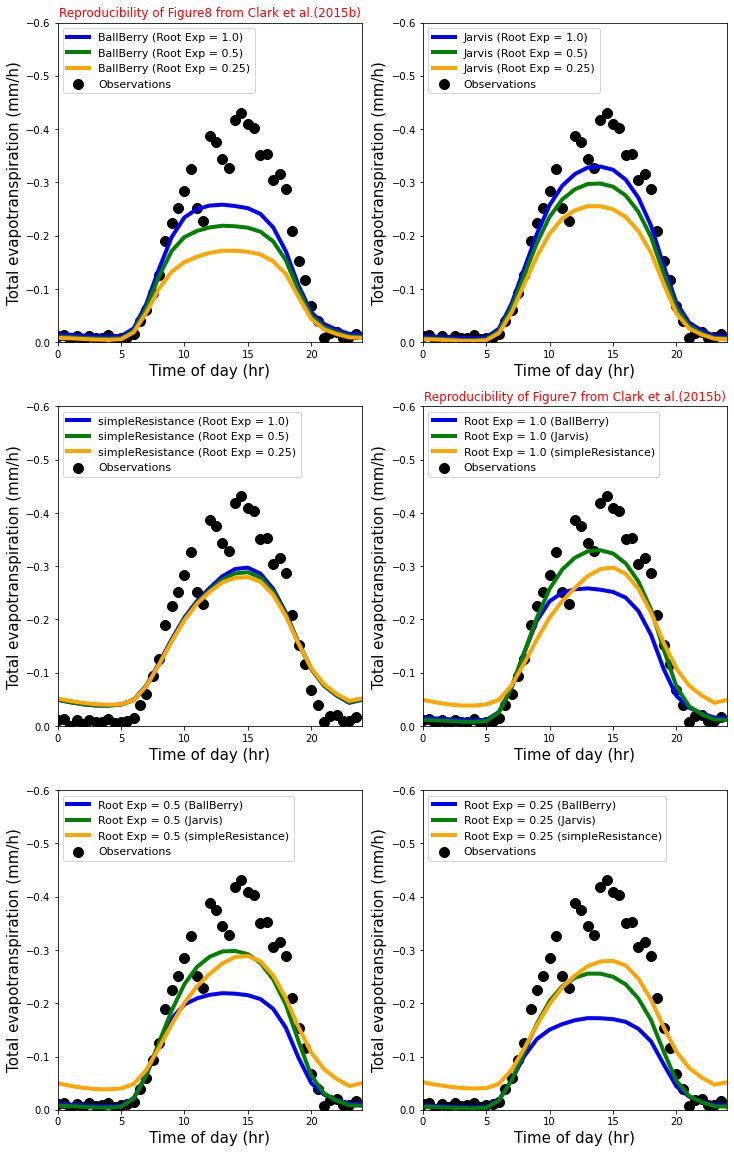

In [19]:
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(321)
ax1.set_title("Reproducibility of Figure8 from Clark et al.(2015b)", fontsize=12, color='red')
ax1.plot(BallBerry_rootDisExp_1_0_hour.index, BallBerry_rootDisExp_1_0_hour['ET'], label='BallBerry (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax1.plot(BallBerry_rootDisExp_0_5_hour.index, BallBerry_rootDisExp_0_5_hour['ET'], label='BallBerry (Root Exp = 0.5)', color='green', linewidth=4.0)
ax1.plot(BallBerry_rootDisExp_0_25_hour.index, BallBerry_rootDisExp_0_25_hour['ET'], label='BallBerry (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax2 = fig.add_subplot(322)
ax2.plot(Jarvis_rootDisExp_1_0_hour.index, Jarvis_rootDisExp_1_0_hour['ET'], label='Jarvis (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax2.plot(Jarvis_rootDisExp_0_5_hour.index, Jarvis_rootDisExp_0_5_hour['ET'], label='Jarvis (Root Exp = 0.5)', color='green', linewidth=4.0)
ax2.plot(Jarvis_rootDisExp_0_25_hour.index, Jarvis_rootDisExp_0_25_hour['ET'], label='Jarvis (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax3 = fig.add_subplot(323)
ax3.plot(simpleResistance_rootDisExp_1_0_hour.index, simpleResistance_rootDisExp_1_0_hour['ET'], label='simpleResistance (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax3.plot(simpleResistance_rootDisExp_0_5_hour.index, simpleResistance_rootDisExp_0_5_hour['ET'], label='simpleResistance (Root Exp = 0.5)', color='green', linewidth=4.0)
ax3.plot(simpleResistance_rootDisExp_0_25_hour.index, simpleResistance_rootDisExp_0_25_hour['ET'], label='simpleResistance (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax4 = fig.add_subplot(324)
ax4.set_title("Reproducibility of Figure7 from Clark et al.(2015b)", fontsize=12, color='red')
ax4.plot(rootDisExp_1_0_BallBerry_hour.index, rootDisExp_1_0_BallBerry_hour['ET'], label='Root Exp = 1.0 (BallBerry)', color='blue', linewidth=4.0)
ax4.plot(rootDisExp_1_0_Jarvis_hour.index, rootDisExp_1_0_Jarvis_hour['ET'], label='Root Exp = 1.0 (Jarvis)', color='green', linewidth=4.0)
ax4.plot(rootDisExp_1_0_simpleResistance_hour.index, rootDisExp_1_0_simpleResistance_hour['ET'], label='Root Exp = 1.0 (simpleResistance)', color='orange', linewidth=4.0)

ax5 = fig.add_subplot(325)
ax5.plot(rootDisExp_0_5_BallBerry_hour.index, rootDisExp_0_5_BallBerry_hour['ET'], label='Root Exp = 0.5 (BallBerry)', color='blue', linewidth=4.0)
ax5.plot(rootDisExp_0_5_Jarvis_hour.index, rootDisExp_0_5_Jarvis_hour['ET'], label='Root Exp = 0.5 (Jarvis)', color='green', linewidth=4.0)
ax5.plot(rootDisExp_0_5_simpleResistance_hour.index, rootDisExp_0_5_simpleResistance_hour['ET'], label='Root Exp = 0.5 (simpleResistance)', color='orange', linewidth=4.0)

ax6 = fig.add_subplot(326)
ax6.plot(rootDisExp_0_25_BallBerry_hour.index, rootDisExp_0_25_BallBerry_hour['ET'], label='Root Exp = 0.25 (BallBerry)', color='blue', linewidth=4.0)
ax6.plot(rootDisExp_0_25_Jarvis_hour.index, rootDisExp_0_25_Jarvis_hour['ET'], label='Root Exp = 0.25 (Jarvis)', color='green', linewidth=4.0)
ax6.plot(rootDisExp_0_25_simpleResistance_hour.index, rootDisExp_0_25_simpleResistance_hour['ET'], label='Root Exp = 0.25 (simpleResistance)', color='orange', linewidth=4.0)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for ax in axes:
    # invert y axis
    ax.invert_yaxis()
    # plot scatter with x='xvals', y='Observation (aspen)'
    ax.scatter(xvals, df_gp_hr['Observations'], color='black', s=100, label="Observations")
    # add x, y label
    ax.set_xlabel('Time of day (hr)', fontsize=15)
    ax.set_ylabel('Total evapotranspiration (mm/h)', fontsize=15)
    # show up the legend
    ax.legend(fontsize=11, loc=2)
    ax.set_xlim([0,24])
    ax.set_ylim([0,-0.6])

### Cleanup

In [20]:
! rm -rvf {unzip_dir} {job_dir}

removed '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistance/data/forcingData/forcing_above_aspen.nc'
removed directory '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistance/data/forcingData'
removed '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistance/data/gis/Reynolds_Creek_watershed_wgs84.cpg'
removed '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistance/data/gis/Reynolds_Creek_watershed_wgs84.dbf'
removed '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistance/data/gis/Reynolds_Creek_watershed_wgs84.prj'
removed '/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/tmpajxl1g_c/SummaModel_ReynoldsAspenStand_StomatalResistanc

# Done

In [21]:
import xarray as xr

In [22]:
out_file_paths[0][0]

'/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.25++_timestep.nc'

In [23]:
xr.open_dataset(out_file_paths[0][0]).scalarLatHeatTotal

<xarray.DataArray 'scalarLatHeatTotal' (time: 10945, hru: 1)>
array([[-77.55954 ],
       [-40.131299],
       [-54.500089],
       ...,
       [-17.311385],
       [-17.085929],
       [-18.764911]])
Coordinates:
  * time     (time) datetime64[ns] 2006-07-01 ... 2007-09-30
  * hru      (hru) int32 1
Attributes:
    long_name:  latent heat from the canopy air space to the atmosphere (inst...
    units:      W m-2

In [24]:
out_file_paths[1][0]

'/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.5++_timestep.nc'

In [25]:
xr.open_dataset(out_file_paths[1][0]).scalarLatHeatTotal

<xarray.DataArray 'scalarLatHeatTotal' (time: 10945, hru: 1)>
array([[-77.55954 ],
       [-40.131318],
       [-54.500131],
       ...,
       [-17.921854],
       [-17.620862],
       [-19.271865]])
Coordinates:
  * time     (time) datetime64[ns] 2006-07-01 ... 2007-09-30
  * hru      (hru) int32 1
Attributes:
    long_name:  latent heat from the canopy air space to the atmosphere (inst...
    units:      W m-2

In [26]:
out_file_paths[2][0]

'/home/jovyan/work/job-supervisor-python-sdk/examples/workspace/1600748763SWSW/output/vegImpactsTranspire_++BallBerry++rootDistExp=1.0++_timestep.nc'

In [27]:
xr.open_dataset(out_file_paths[2][0]).scalarLatHeatTotal

<xarray.DataArray 'scalarLatHeatTotal' (time: 10945, hru: 1)>
array([[-77.55954 ],
       [-40.131327],
       [-54.500151],
       ...,
       [-18.236668],
       [-17.892471],
       [-19.516136]])
Coordinates:
  * time     (time) datetime64[ns] 2006-07-01 ... 2007-09-30
  * hru      (hru) int32 1
Attributes:
    long_name:  latent heat from the canopy air space to the atmosphere (inst...
    units:      W m-2